In [1]:
from __future__ import division
import numpy as np
from numpy import fft
from scipy import signal, ndimage, misc, fftpack
import bitarray
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import reedsolo
import serial
%matplotlib inline

import Encoding
import Transmission
import RiFiJPEG

import pyaudio
import operator

import Queue 
import threading
import time
import ax25
multi = False

In [2]:
def PSNR(im_truth, im_test, maxval=255.):
    mse = np.linalg.norm(im_truth.astype(np.float64) - im_test.astype(np.float64))**2 / np.prod(np.shape(im_truth))
    return 10 * np.log10(maxval**2 / mse) 

In [3]:
def downsample(data, targetsize=(256,256)):

    
    data = signal.resample(data, targetsize[0], axis=0)
    data = signal.resample(data, targetsize[1], axis=1)

    return data

def upsample(data, targetsize=None):

    data = signal.resample(data, targetsize[0], axis=0)
    data = signal.resample(data, targetsize[1], axis=1)

    return data
def factordownsample(data, factor=5):
    y = data.shape[0]
    x = data.shape[1]
    return downsample(data, targetsize=(y//factor, x//factor))


In [115]:
IMG_DIR = 'Images/'
IMG_NAME = 'calBlue.tiff'

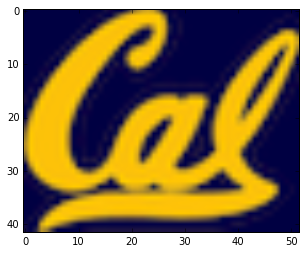

In [116]:
img = ndimage.imread(IMG_DIR + IMG_NAME)
plt.imshow(img)
plt.show()

In [99]:
def findPackets4(bits, rs=reedsolo.RSCodec(30)):
        # function take a bitarray and looks for AX.25 packets in it. 
        # It implements a 2-state machine of searching for flag or collecting packets
                
        flg = bitarray.bitarray([0,1,1,1,1,1,1,1,1,1,1,0])
        packets = []
        n = 0
        pktcounter = 0
        packet = []
        state = 'search'
        cnt = 0
        # Loop over bits
        junkers = []
        while (n < len(bits)-11) :
            cnt += 1
            
            # default state is searching for packets
            if state is 'search':
                
                # look for 1111110, because can't be sure if the first zero is decoded
                # well if the packet is not padded.
                if bits[n:n+11] == flg[1:]:
                    
                    # flag detected, so switch state to collecting bits in a packet
                    # start by copying the flag to the packet
                    # start counter to count the number of bits in the packet
                    state = 'pkt'
                    packet=flg.copy()
                    pktcounter = 12                    
                    # Advance to the end of the flag
                    n = n + 11
                else:
                    # flag was not found, advance by 1
                    n = n + 1            
        
            # state is to collect packet data. 
            elif state is 'pkt':
                #print cnt, 'cnt', n
                #print bits[n:n+7], flg[:7], pktcounter
                # Check if we reached a flag by comparing with 0111111
                # 6 times ones is not allowed in a packet, hence it must be a flag (if there's no error)
                if bits[n:n+11] == flg[:11]:
                    # Flag detected, check if packet is longer than some minimum
                    if pktcounter > 240:
                        # End of packet reached! append packet to list and switch to searching state
                        # We don't advance pointer since this our packet might have been
                        # flase detection and this flag could be the beginning of a real packet
                        state = 'search'
                        packet.extend(flg)
                        p = packet.copy()
                        p = ax25.bit_unstuff(p[12:-12])
                        try:
                          p = bitarray.bitarray(np.unpackbits(rs.decode(bytearray(bitarray.bitarray(p.to01()).tobytes()))).tolist())
                          p = p[:-8]#ignoring checksum logic for now
                          packets.append(p)
                        except:
                          print 'error will robinson'
                          junkers.append((p, packet))
                          state = 'search'
                    else:
                        # packet is too short! false alarm. Keep searching 
                        # We don't advance pointer since this this flag could be the beginning of a real packet
                        state = 'search'
                # No flag, so collect the bit and add to the packet
                else:
                    # check if packet is too long... if so, must be false alarm
                    if pktcounter < 2680:
                        # Not a false alarm, collect the bit and advance pointer                        
                        packet.append(bits[n])
                        pktcounter = pktcounter + 1
                        n = n + 1
                    else:  
                        #runaway packet, switch state to searching, and advance pointer
                        state = 'search'
                        n = n + 1
        return packets, junkers

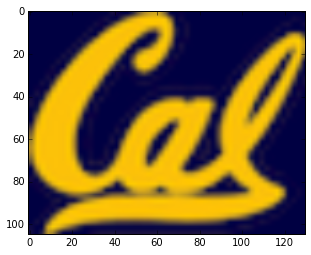

In [122]:
#img2 = factordownsample(img, 2)
if img.shape[0]*img.shape[1] > 2500:
    img2 = misc.imresize(img, 27/100)
else:
    img2 = img
im3 =  misc.imresize(img2, 100/40)
plt.imshow(im3)
#print PSNR(img, im3)

In [130]:
def resize(img):
    if img.shape[0]*img.shape[1] > 2500:
        return True
    else:
        return False

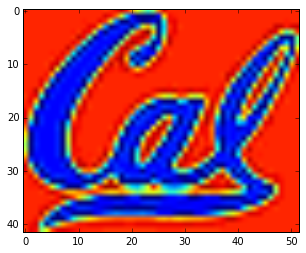

In [127]:
plt.imshow(img[:,:,2])

In [131]:
a = 1
tsize, ssize, Y, Cb, Cr, Rlim, Glim, Blim = RiFiJPEG.RiFi_preprocess(img2, a)
if not resize(img):
    Y = img[:,:,0]
    Cb = img[:,:,1]
    Cr = img[:,:,2]
### TRANSMIT: img.shape[:2], tsize, ssize, Y, Cb, Cr ###

imgRecon = RiFiJPEG.RiFi_postprocess(Y, Cb, Cr, tsize, ssize, (img.shape[0], img.shape[1]), a, Rlim, Glim, Blim)

IndexError: index 52 is out of bounds for axis 1 with size 52

17.9008689545


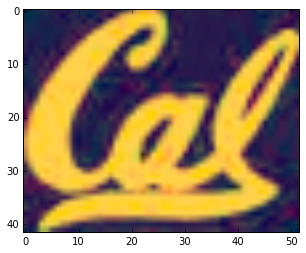

In [124]:
plt.imshow(imgRecon)
print PSNR(img, imgRecon)

In [103]:
reload(Encoding)
reload(Transmission)

def printDevNumbers(p):
    N = p.get_device_count()
    for n in range(0,N):
        name = p.get_device_info_by_index(n).get('name')
        print n, name

p = pyaudio.PyAudio()
printDevNumbers(p)
p.terminate()

eY = Encoding.encode(Y, Encoding.huffmanLookupLuminanceDC, Encoding.huffmanLookupLuminanceAC)
a = len(eY)
# _ = Transmission.testTransmit(e)

eCb = Encoding.encode(Cb, Encoding.huffmanLookupChrominanceDC, Encoding.huffmanLookupChrominanceAC)
b = len(eCb)
# Transmission.testTransmit(e)

eCr = Encoding.encode(Cr, Encoding.huffmanLookupChrominanceDC, Encoding.huffmanLookupChrominanceAC)
c = len(eCr)
# Transmission.testTransmit(e)

print (a+b+c)//8
print img.shape[0]*img.shape[1]*3

0 Microsoft Sound Mapper - Input
1 Microphone (2- USB PnP Sound De
2 Microphone (VIA HD Audio(Compat
3 Microphone (2- C-Media USB Head
4 Microsoft Sound Mapper - Output
5 Digital Audio (HDMI) (2- High D
6 Speakers (VIA HD Audio(Compatib
7 Headphone (VIA HD Audio(Compati
8 Speakers (2- C-Media USB Headph
9 Speakers (2- USB PnP Sound Devi
2836
2400000


In [104]:
dusb_in = 3
dusb_out = 9
d_in = 9
d_out = 9

In [105]:
reload(Transmission)
reload(Encoding)
multi = False
bits = Transmission.bitStreamify(range(9), Y, Cb, Cr)
if multi:
    atest = Transmission.packetize2(bits)
else:
    atest = Transmission.packetize(bits)
# print Transmission.packetize(eY)
# test = Transmission.NRZ2NRZI(test)
NRZI = bitarray.bitarray()
baud = 1200
fc = 2450
fd = 1200
print len(atest)
for packet in atest:
    if not multi:
        sig = Transmission.afsk1200(packet, 48e3, baud = baud, fc = fc, fd = fd)
        analog = Transmission.nc_afsk1200Demod(sig, TBW=2.0, baud = baud, f1 = fc-fd, f2 = fc+fd)
        signed = np.sign(analog)
        idx = Transmission.PLL(analog, fs=48e3, baud=baud).astype(int)
        samples = bitarray.bitarray([bit >= 0 for bit in np.array(analog)[idx]])
#     bits = Transmission.NRZI2NRZ(samples)

        NRZI += samples
    else:
        sig = Transmission.mafsk1200(packet, 48e3, baud = baud)
        kks = Transmission.nc_mafsk1200Demod(sig, TBW=2.0, baud = baud)
        plloc = Transmission.mafsk2crossings(kks)
        bindex2 = Transmission.mPLL(plloc, baud=baud)
        locs2 = Transmission.mafsk2barr(kks, indii = bindex2) 
        samples = bitarray.bitarray([True if x == 1 else False for x in locs2])
        
#     bits = Transmission.NRZI2NRZ(samples)

        NRZI += samples
#     plt.figure(figsize=(20,5))
#     plt.plot(analog[-2000:])
#     plt.stem(idx[-35:]-idx[-35]+620, analog[idx[-35:]])
if multi:
    fp = findPackets4(Transmission.NRZI2NRZ(NRZI))
else:
    fp = Transmission.findPackets2(Transmission.NRZI2NRZ(NRZI))
# print reduce(operator.add, test)
# print NRZI[:100]
# print Transmission.NRZI2NRZ(NRZI)[:100]
# # print Transmission.packetize(eY)
# # print Transmission.findPackets(Transmission.NRZI2NRZ(test))
# print Transmission.NRZI2NRZ(NRZI)
# print len(Transmission.findPackets2(Transmission.NRZI2NRZ(NRZI)))
test = reduce(operator.add, fp)
with open("eY.txt", "w") as text_file:
    for t in Transmission.justPacketize(bits):
        text_file.write(t.to01())
        text_file.write("\n")
with open('nrzi.txt', 'w') as text_file:
    text_file.write(NRZI.to01())
with open("test.txt", "w") as text_file:
#     text_file.write(Transmission.NRZI2NRZ(NRZI).to01())
    for t in Transmission.findPackets2(Transmission.NRZI2NRZ(NRZI)):
        text_file.write(t.to01())
        text_file.write("\n")
print len(Transmission.findPackets2(Transmission.NRZI2NRZ(NRZI)))
size, dY, dCb, dCr = Transmission.deStreamify(test)
# print test[:,0]
# print Y[:,0]
print size
print np.sum(dY != Y)
print np.sum(dCb != Cb)
print np.sum(dCr != Cr)
# print test.to01() == eY.to01()

15
15
[0, 1, 2, 3, 4, 5, 6, 7, 8]
0
0
0


In [106]:
w = Transmission.NRZI2NRZ(atest[0])
w

bitarray('011111100111111001111110011111100111111001111110011111100111111001111110011111100111111000000000000000000000000000000001000000000000001000000000000000110000000000000100000000000000010100000110000001110000100001111101111100110001001011110111101000101001001010001010001010001010001010001010001010001010010110100010100101110110001110011111011100001011011111010010001101001011101100011111011111001110101101111101001000110100110100101010010001110101000001000111110010100000110100100101000101000101000101000101000101001011010001010001010010110100010100101101001101001111001001001111100111001101001001010001010001010010010100010100010100101101000101000101010011001011000101100111110101111011111010010111110111000100110101011001010101000000101111011000011111010000110000011111011111011010111101001111101011100101000000111011100011111010000101010001001100111011001101110000100000001001111101100111010011011100010010011101110110110001111011011101011010011000011000111100111101011110011111011000011000

In [107]:
e = fp[1][0]
e

True

In [108]:
w2 = w[132:]
e2 = e[1][12:]
g= []
for i in range(len(e2)):
    try:
        if e2[i]!=w2[i]:
            g.append(i)
    except:
        print 'ww'
        pass
print len(g)/len(e2)
g

TypeError: 'bool' object has no attribute '__getitem__'

In [ ]:
print w2[100:120]
print e2[100:120]
w2[:-12*11]

In [ ]:
e3 = e2[:-12]
w3 = w2[:-12*11]
e4 = bytearray(bitarray.bitarray(e3.to01()).tobytes())
w4 = bytearray(bitarray.bitarray(w3.to01()).tobytes())
rs = reedsolo.RSCodec(30)
rs.decode(w4)

In [109]:
print Y.flatten().shape[0]+Cr.flatten().shape[0]+Cb.flatten().shape[0]
print len(eY)+len(eCb)+len(eCr)
print img.shape[0]*img.shape[1]*img.shape[2]

89216
22688
2400000


In [110]:
reload(Encoding)
reload(Transmission)
try:
    s = serial.Serial(port='/dev/ttyUSB0')
except:
    s = serial.Serial(port='COM3')
s.setDTR(0)
starttime = time.time()
Qin = Queue.Queue()
cQin = Queue.Queue()
Qout = Queue.Queue()
cQout = Queue.Queue()
multi = False
p = pyaudio.PyAudio()
im2 = img.reshape(3, img.shape[0], img.shape[1])
fs_usb = 48e3
rate = 2
t_rec = threading.Thread(target = Transmission.record_audio,   args = (Qin, cQin, p, fs_usb, dusb_in, 512))
t_rec.start()
time.sleep(1)
packets2 = Transmission.packetize(Transmission.bitStreamify(range(9), Y, Cb, Cr), rs=reedsolo.RSCodec(30))
#Transmission.packetize(Transmission.bitStreamify(range(9), im2[0],im2[1] ,im2[2]), rs=reedsolo.RSCodec(30))

if not multi:
    toSend = [Transmission.afsk1200(packet, 48e3, baud =baud, fc=fc,fd=fd) for packet in packets2]
else:
    toSend = [Transmission.mafsk1200(packet, 48e3, baud = 1200*rate) for packet in packets2]
print len(toSend)
for i, sig in enumerate(toSend):
    Qout.put("KEYON")
#     Qout.put(Transmission.afsk1200(bitarray.bitarray("01"*10)))
    Qout.put(sig)
    Qout.put("KEYOFF")
    Qout.put(np.zeros(fs_usb//7))    
Qout.put("EOT")

Transmission.play_audio(Qout, cQout, p, fs_usb, dusb_out, s,keydelay =0.5)
i = 0
#while not(Qout.empty()) :
#    time.sleep(2)
#    print i
#    i += 1
print 'reeee'
time.sleep(1)
cQin.put('EOT')
time.sleep(2) # give time for the thread to get killed


p.terminate()
s.close()
print time.time()-starttime
recorded = []
while not (Qin.empty()):
    recorded.append(Qin.get())

15


D:\Anaconda\lib\site-packages\ipykernel\__main__.py:34: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Closed  play thread
reeee
Closed  record thread
37.3910000324


[0, 1, 2, 3, 4, 5, 6, 7, 8]
0
0
0


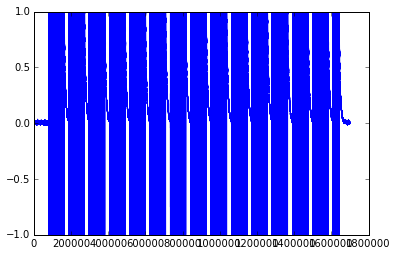

In [111]:
# NRZI = bitarray.bitarray()
# for packet in test:
#     sig = Transmission.afsk1200(packet, 48e3)
#     analog = Transmission.nc_afsk1200Demod(sig, TBW=2.0)
#     idx = Transmission.PLL(analog, fs=48e3).astype(int)
#     samples = bitarray.bitarray([bit >= 0 for bit in np.array(analog)[idx]])

#     NRZI += samples

fs = 48e3
data = np.array(recorded).flatten()
plt.plot(data)
if not multi:
    demod = Transmission.nc_afsk1200Demod(data, fs, baud = baud,f1=fc-fd,f2=fc+fd)
    idx = Transmission.PLL(demod, fs=fs, baud=baud).astype(int)
    samples = bitarray.bitarray([bit >= 0 for bit in np.array(demod)[idx]])
else:
    kks = Transmission.nc_mafsk1200Demod(data, baud=1200*rate)#, fc = 2700, fd = 1000)
    plloc = Transmission.mafsk2crossings(kks)
    bindex2 = Transmission.mPLL(plloc, baud=1200*rate)
    locs2 = Transmission.mafsk2barr(kks, indii = bindex2) 
    samples = bitarray.bitarray([True if x == 1 else False for x in locs2])
    
bits = Transmission.NRZI2NRZ(samples)
packets = Transmission.findPackets2(bits, rs=reedsolo.RSCodec(30))

test = reduce(operator.add, packets)

with open("eY.txt", "w") as text_file:
    for t in Transmission.justPacketize(Transmission.bitStreamify(range(9), Y, Cb, Cr)):
        text_file.write(t.to01())
        text_file.write("\n")
with open("test.txt", "w") as text_file:
    for t in packets:
        text_file.write(t.to01())
        text_file.write("\n")
with open("test2.txt", "w") as text_file:
    text_file.write(bits.to01())
with open('test3.txt', 'w') as text_file:
    for s in packets2:
        text_file.write(s.to01())
        text_file.write("\n")
# test = Encoding.decode(iter(test), Encoding.huffmanRootLuminanceDC, Encoding.huffmanRootLuminanceAC)
# print test[:,0]
# print Y[:,0]
# print np.sum(test != Y)
# test = Encoding.decode(iter(test), Encoding.huffmanRootLuminanceDC, Encoding.huffmanRootLuminanceAC)

# print np.sum(test != Y)
# print bits[:100]
# print reduce(operator.add, Transmission.packetize(eY))[:100]

size, dY, dCb, dCr = Transmission.deStreamify(test)
#dY, dCb, dCr = Transmission.deStreamify(test)
# print test[:,0]
# print Y[:,0]
print size
print np.sum(dY != Y)
print np.sum(dCb != Cb)
print np.sum(dCr != Cr)

In [112]:
Transmission.NRZI2NRZ(packets2[0]).to01()


'011111100111111001111110011111100111111001111110011111100111111001111110011111100111111000000000000000000000000000000001000000000000001000000000000000110000000000000100000000000000010100000110000001110000100001111101111100110001001011110111101000101001001010001010001010001010001010001010001010001010010110100010100101110110001110011111011100001011011111010010001101001011101100011111011111001110101101111101001000110100110100101010010001110101000001000111110010100000110100100101000101000101000101000101000101001011010001010001010010110100010100101101001101001111001001001111100111001101001001010001010001010010010100010100010100101101000101000101010011001011000101100111110101111011111010010111110111000100110101011001010101000000101111011000011111010000110000011111011111011010111101001111101011100101000000111011100011111010000101010001001100111011001101110000100000001001111101100111010011011100010010011101110110110001111011011101011010011000011000111100111101011110011111011000011000101001100

In [113]:
print len(Y)
print len(dY)

print (Y)
print (dY)
print np.where(Y!=dY)
print Y.shape
print Cb.shape
plt.imshow(img.reshape(3, 42, 52)[0])

918
918
[[ 5.  0.  0. ...,  0.  0.  0.]
 [ 5.  0.  0. ...,  0.  0.  0.]
 [ 4.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 7.  0.  0. ...,  0.  0.  0.]
 [ 7.  0.  0. ...,  0.  0.  0.]
 [ 8. -1.  0. ...,  0.  0.  0.]]
[[ 5.  0.  0. ...,  0.  0.  0.]
 [ 5.  0.  0. ...,  0.  0.  0.]
 [ 4.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 7.  0.  0. ...,  0.  0.  0.]
 [ 7.  0.  0. ...,  0.  0.  0.]
 [ 8. -1.  0. ...,  0.  0.  0.]]
(array([], dtype=int64), array([], dtype=int64))
(918L, 64L)
(238L, 64L)


ValueError: total size of new array must be unchanged

26.2791456401


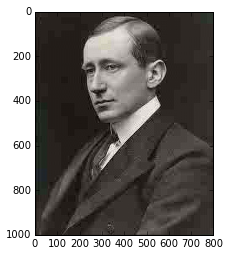

In [114]:
bitsY, bitsCb, bitsCr, targetsize, subsize, originalsize, quality, Rlim, Glim, Blim = Y, Cb, Cr, tsize, ssize, (img.shape[0], img.shape[1]), 1, Rlim, Glim, Blim
im2 = RiFiJPEG.RiFi_postprocess(dY, dCb, dCr, targetsize, subsize, originalsize, quality, Rlim, Glim, Blim)
plt.imshow(im2)
print PSNR(im2, img)

In [ ]:
packets = findPackets(bits, rs=reedsolo.RSCodec(150))
packets

In [ ]:
def findPackets3(bits, rs=reedsolo.RSCodec(30)):
        # function take a bitarray and looks for AX.25 packets in it. 
        # It implements a 2-state machine of searching for flag or collecting packets
                
        flg = bitarray.bitarray([0,1,1,1,1,1,1,1,0])
        packets = []
        n = 0
        pktcounter = 0
        packet = []
        state = 'search'
        cnt = 0
        # Loop over bits
        while (n < len(bits)-8) :
            cnt += 1
            
            # default state is searching for packets
            if state is 'search':
                
                # look for 1111110, because can't be sure if the first zero is decoded
                # well if the packet is not padded.
                if bits[n:n+8] == flg[1:]:
                    
                    # flag detected, so switch state to collecting bits in a packet
                    # start by copying the flag to the packet
                    # start counter to count the number of bits in the packet
                    state = 'pkt'
                    packet=flg.copy()
                    pktcounter = 9                    
                    # Advance to the end of the flag
                    n = n + 8
                else:
                    # flag was not found, advance by 1
                    n = n + 1            
        
            # state is to collect packet data. 
            elif state is 'pkt':
                #print cnt, 'cnt', n
                #print bits[n:n+7], flg[:7], pktcounter
                # Check if we reached a flag by comparing with 0111111
                # 6 times ones is not allowed in a packet, hence it must be a flag (if there's no error)
                if bits[n:n+8] == flg[:8]:
                    # Flag detected, check if packet is longer than some minimum
                    if pktcounter > 240:
                        # End of packet reached! append packet to list and switch to searching state
                        # We don't advance pointer since this our packet might have been
                        # flas e detection and this flag could be the beginning of a real packet
                        state = 'search'
                        packet.extend(flg)
                        return packet
                        p = packet.copy()
                        p = ax25.bit_unstuff(p[9:-9])
                        try:
                          p = bitarray.bitarray(np.unpackbits(rs.decode(bytearray(bitarray.bitarray(p.to01()).tobytes()))).tolist())
                          p = p[:-8]#ignoring checksum logic for now
                          packets.append(p)
                        except:
                          print 'error will robinson'
                          state = 'search'
                    else:
                        # packet is too short! false alarm. Keep searching 
                        # We don't advance pointer since this this flag could be the beginning of a real packet
                        state = 'search'
                # No flag, so collect the bit and add to the packet
                else:
                    # check if packet is too long... if so, must be false alarm
                    if pktcounter < 2680:
                        # Not a false alarm, collect the bit and advance pointer                        
                        packet.append(bits[n])
                        pktcounter = pktcounter + 1
                        n = n + 1
                    else:  
                        #runaway packet, switch state to searching, and advance pointer
                        state = 'search'
                        n = n + 1
#        return packets

def findPackets3b(bits, rs=reedsolo.RSCodec(30)):
        # function take a bitarray and looks for AX.25 packets in it. 
        # It implements a 2-state machine of searching for flag or collecting packets
                
        flg = bitarray.bitarray([0,1,1,1,1,1,1,1,0])
        packets = []
        n = 0
        pktcounter = 0
        packet = []
        state = 'search'
        cnt = 0
        # Loop over bits
        while (n < len(bits)-8) :
            cnt += 1
            
            # default state is searching for packets
            if state is 'search':
                
                # look for 1111110, because can't be sure if the first zero is decoded
                # well if the packet is not padded.
                if bits[n:n+8] == flg[1:]:
                    
                    # flag detected, so switch state to collecting bits in a packet
                    # start by copying the flag to the packet
                    # start counter to count the number of bits in the packet
                    state = 'pkt'
                    packet=flg.copy()
                    pktcounter = 9                    
                    # Advance to the end of the flag
                    n = n + 8
                else:
                    # flag was not found, advance by 1
                    n = n + 1            
        
            # state is to collect packet data. 
            elif state is 'pkt':
                #print cnt, 'cnt', n
                #print bits[n:n+7], flg[:7], pktcounter
                # Check if we reached a flag by comparing with 0111111
                # 6 times ones is not allowed in a packet, hence it must be a flag (if there's no error)
                if bits[n:n+8] == flg[:8]:
                    # Flag detected, check if packet is longer than some minimum
                    if pktcounter > 240:
                        # End of packet reached! append packet to list and switch to searching state
                        # We don't advance pointer since this our packet might have been
                        # flase detection and this flag could be the beginning of a real packet
                        state = 'search'
                        packet.extend(flg)
                        p = packet.copy()
                        p = ax25.bit_unstuff(p[9:-9])
                        try:
                          p = bitarray.bitarray(np.unpackbits(rs.decode(bytearray(bitarray.bitarray(p.to01()).tobytes()))).tolist())
                          p = p[:-8]#ignoring checksum logic for now
                          packets.append(p)
                        except:
                          print 'error will robinson'
                          state = 'search'
                    else:
                        # packet is too short! false alarm. Keep searching 
                        # We don't advance pointer since this this flag could be the beginning of a real packet
                        state = 'search'
                # No flag, so collect the bit and add to the packet
                else:
                    # check if packet is too long... if so, must be false alarm
                    if pktcounter < 2680:
                        # Not a false alarm, collect the bit and advance pointer                        
                        packet.append(bits[n])
                        pktcounter = pktcounter + 1
                        n = n + 1
                    else:  
                        #runaway packet, switch state to searching, and advance pointer
                        state = 'search'
                        n = n + 1
        return packets

def findPackets2a(bits, rs=reedsolo.RSCodec(30)):
        # function take a bitarray and looks for AX.25 packets in it. 
        # It implements a 2-state machine of searching for flag or collecting packets
                
        flg = bitarray.bitarray([0,1,1,1,1,1,1,0])
        packets = []
        n = 0
        pktcounter = 0
        packet = []
        state = 'search'
        
        # Loop over bits
        while (n < len(bits)-7) :
            
            # default state is searching for packets
            if state is 'search':
                
                # look for 1111110, because can't be sure if the first zero is decoded
                # well if the packet is not padded.
                if bits[n:n+7] == flg[1:]:
                    
                    # flag detected, so switch state to collecting bits in a packet
                    # start by copying the flag to the packet
                    # start counter to count the number of bits in the packet
                    state = 'pkt'
                    packet=flg.copy()
                    pktcounter = 8                    
                    # Advance to the end of the flag
                    n = n + 7
                else:
                    # flag was not found, advance by 1
                    n = n + 1            
        
            # state is to collect packet data. 
            elif state is 'pkt':
                # Check if we reached a flag by comparing with 0111111
                # 6 times ones is not allowed in a packet, hence it must be a flag (if there's no error)
                if bits[n:n+7] == flg[:7]:
                    # Flag detected, check if packet is longer than some minimum
                    if pktcounter > 180:
                        print 'ww'
                        return packet
                        # End of packet reached! append packet to list and switch to searching state
                        # We don't advance pointer since this our packet might have been
                        # flase detection and this flag could be the beginning of a real packet
                        state = 'search'
                        packet.extend(flg)
                        p = packet.copy()
                        try:
                          # p = ax25.bit_unstuff(p[8:-8])
                          # p = bitarray.bitarray(np.unpackbits(rs.decode(bytearray(bitarray.bitarray(p.to01()).tobytes()))).tolist())
                          p = checkPacket(p, FLAG_NUM, FLAG_NUM)
                          if p:
                            p = p[:-8]#ignoring checksum logic for now
                            packets.append(p)
                          else:
                            state = 'search'
                        except:
                          state = 'search'
                    else:
                        # packet is too short! false alarm. Keep searching 
                        # We don't advance pointer since this this flag could be the beginning of a real packet
                        state = 'search'
                # No flag, so collect the bit and add to the packet
                else:
                    # check if packet is too long... if so, must be false alarm
                    if pktcounter < 2680:
                        # Not a false alarm, collect the bit and advance pointer                        
                        packet.append(bits[n])
                        pktcounter = pktcounter + 1
                        n = n + 1
                    else:  
                        #runaway packet, switch state to searching, and advance pointer
                        state = 'search'
                        n = n + 1
        return packets


In [ ]:
def de6(packet, maxones=6):
    start = 0
    vec = bitarray.bitarray([True]*maxones)
    while start < len(packet)-7:
        cur = packet[start:start+6]:
        if cur == vec:
            if packet[start+6]:
                packet[start+6] = False
    return packet

In [ ]:
w3 =  Transmission.NRZI2NRZ(packets2[0])
print w3
g = []
for i in range(len(w3)):
    try:
        if w3[i] != bits[0:][i]:
            g.append(i)
    except:
        pass
print len(g), len(w3)
print g
#print bits
#e = findPackets3(bits)
test = findPackets3b(w3, rs = reedsolo.RSCodec(30))
test

In [ ]:
ber = [int(x) for x in '011111110011111100111111000000000000000000000000000000001000000000000001000000000000000110000000000000100000000000000010100000110000001110000100000000001111101111100110000111010101011100101101011011001110010110111010011111000001010001100001000000011111010011101110011111010111010101000111101001111101110110100110001111011001011111011000100111100010101101110001101000111011001011010011101000110000110001010000001100111001111000010100101100000000110100100100100011011101111100001100111001110110100000011101110010000001100000000010101010100110101000001100001001011011010010000010011001111000100001000101001010110100100111000010111100011011101101100110000011100111001111010011100000111100000111110011011100010101100001011111011100111110111100111100110100101101011010000100001110100110110111000100101100011001100101111101001010100000110001100101010000111110001110111001110000000000010010011100000000011111001110100011100011100000101101110101111010111101001010101011010110110101101110111101110001001010101100011010011101111101001001011000111101000101010100011101010110001111101010011101101111010100100100011110100101011101010110000001000011011001110000000111000111110001011000111000100101110010010011110111011000111110010100111110010101100110001111101101010011100000010101100000110001110111110101010011011110000110111000100111010000101110001101101001010101000101000110000011111000101000011101101101101000001111011111011111001111011110111001110011010101011110111100101110110110101110111001001101110001000110110101000101000001000010001001110101110000000011110101001001001111101110111100110111011111000011100000000011100010101010011111011111000111110111100111100011101100110101111101011100001010000011000110001110000001000101000001111100010100101001000111001001010000110111100101101011101111000001000000001010011111010100111010010010000101001001110101101000011111001011100010100011001010000011001001010010100000010101111110']

In [ ]:
ber2 =  [int(x) for x in '011111100111111000000000000000000000000000000001000000000000001000000000000000110000000000000100000000000000010100000110000001110000100000000010111101111100110000111010101011100101101011011001110010110111010011111000001010001100001000000011111010011101110011111010111010101000111101001111101110110100110001111011001011111011000100111100010101101110001101000111011001011010011101000110000110001010000001100111001111000010100101100000000110100100100100011011101111100001100111001110110100000011101110010000001100000000010101010100110101000001100001001011011010010000010011001111000100001000101001010110100100111000010111100011011101101100110000011100111001111010011100000111100000111110011011100010101100001011111011100111110111100111100110100101101011010000100001110100110110111000100101100011001100101111101001010100000110001100101010000111110001110111001110000000000010010011100000000011111001110100011100011100000101101110101111010111101001010101011010110110101101110111101110001001010101100011010011101111101001001011000111101000101010100011101010110001111101010011101101111010100100100011110100101011101010110000001000011011001110000000111000111110001011000111000100101110010010011110111011000111110010100111110010101100110001111101101010011100000010101100000110001110111110101010011011110000110111000100111010000101110001101101001010101000101000110000011111000101000011101101101101000001111011111011111001111011110111001110011010101011110111100101110110110101110111001001101110001000110110101000101000001000010001001110101110000000011110101001001001111101110111100110111011111000011100000000011100010101010011111011111000111110111100111100011101100111101011001100110111110001000100000101110000100001001000101000010011000100010101101000000010000010000110111001000100101000101110101011010111110101101010110101111010010011011100001000111100101011001010000101011111011101110011000000011010010010101001001101001101111010011101101011010110111000100111110100111110100110000001011011011101100010010000001001101000100111010011001110001111101101001110110100010101101111110']

In [ ]:
ber = bitarray.bitarray(ber2)
ber
w = findPackets2a(ber)
w

In [ ]:
astar = findPackets3b(bits)
astar

In [ ]:
if True:
    kks = Transmission.nc_mafsk1200Demod(toSend[0], baud=1200*rate)#, fc = 2700, fd = 1000)
    plloc = Transmission.mafsk2crossings(kks)
    bindex2 = Transmission.mPLL(plloc, baud=1200*rate)
    locs2 = Transmission.mafsk2barr(kks, indii = bindex2) 
    samples = bitarray.bitarray([True if x == 1 else False for x in locs2])
    
bits = Transmission.NRZI2NRZ(samples)
packets = Transmission.findPackets2(bits, rs=reedsolo.RSCodec(150))
packets = findPackets3b(bits, rs=reedsolo.RSCodec(150))
packets

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(toSend[0][500:800+800])

In [ ]:
offs = len(kks[0])-400
lim = 500
ymax = 1.7
plt.axis([0.0,lim,-ymax,ymax])
plt.plot(np.abs(kks[0])[offs:offs+lim])
plt.figure()
plt.axis([0.0,lim,-ymax,ymax])

plt.plot(np.abs(kks[1])[offs:offs+lim])
plt.figure()
plt.axis([0.0,lim,-ymax,ymax])

plt.plot(np.abs(kks[2])[offs:offs+lim])
plt.figure()
plt.axis([0.0,lim,-ymax,ymax])

plt.plot(np.abs(kks[3])[offs:offs+lim])
plt.figure()
plt.axis([0.0,lim,-ymax,ymax])

plt.plot((kks[3]-kks[2])[offs:offs+lim])
plt.figure()
plt.axis([0.0,lim,-.5,.5])

plt.plot((kks[0]-kks[1])[offs:offs+lim])
plt.figure()
#plt.plot((kks[0]-kks[2])[:50])


In [ ]:
w2 = findPackets3(w)


In [ ]:
print w2
print e

In [ ]:
g = []
for i in range(len(test)):
    try:
        if test[i] != e[i]:
            g.append(i)
    except:
        print 'ss'
print g
print len(g)
print len(g)/len(w)

In [ ]:
packet.extend(flg)
p = packet.copy()
p = ax25.bit_unstuff(p[8:-8])
try:
  p = bitarray.bitarray(np.unpackbits(rs.decode(bytearray(bitarray.bitarray(p.to01()).tobytes()))).tolist())
  p = p[:-8]#ignoring checksum logic for now
  packets.append(p)
except:
  print 'error will robinson'
  state = 'search'

In [ ]:
packet = findPackets3b(w)
packet

In [ ]:
w3 =  Transmission.NRZI2NRZ(packets2[0])
packet2 = Transmission.findPackets2(w3)
packet2

In [ ]:
packet = e

In [ ]:
w2

In [ ]:
test = findPackets3(w3)
e = findPackets3(bits)
test2 = test.copy()
for x in range(0,23):
    test2[x] = not test[x]
flg2 = bitarray.bitarray([0,1,1,1,1,1,1,1,0])
pck = test2

print test[9:-9]
print test2[9:-9]

#pck.extend(flg2)
p = pck.copy()
p = ax25.bit_unstuff(p[9:-9])
print len(p)
print len(ax25.bit_unstuff(test[9:-9]))
assert 0 ==1
rs = reedsolo.RSCodec(30)
#bitarray.bitarray(np.unpackbits(bytearray(bitarray.bitarray(p.to01()).tobytes())).tolist())
t1 = bytearray(bitarray.bitarray(p.to01()).tobytes())
print t1, 'p'
for i in range(0, 16):
    #t1[i] = '\x55'
    pass
print t1, 'p0'
pa = bitarray.bitarray(np.unpackbits(rs.decode(t1)).tolist())
#pa[:-8]

In [ ]:
t1

In [ ]:
t1

In [ ]:
packet2